## 개요

### 목표

- 신용카드 사용 내역 데이터를 활용한 지역별, 업종별 월간 카드 사용 총액 예측

### features
* REG_YYMM : 년월
* CARD_SIDO_NM : 카드이용지역_시도 (가맹점 주소 기준)
* CARD_CCG_NM : 카드이용지역_시군구 (가맹점 주소 기준)
* STD_CLSS_NM : 업종명
* HOM_SIDO_NM : 거주지역_시도 (고객 집주소 기준)
* HOM_CCG_NM : 거주지역_시군구 (고객 집주소 기준)
* AGE : 연령대
* SEX_CTGO_CD : 성별 (1: 남성, 2: 여성)
* FLC : 가구생애주기 (1: 1인가구, 2: 영유아자녀가구, 3: 중고생자녀가구, 4: 성인자녀가구, 5: 노년가구)
* CSTMR_CNT : 이용고객수 (명)
* AMT : 이용금액 (원)
* CNT : 이용건수 (건)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import datetime
from sklearn.preprocessing import LabelEncoder
#한글깨짐방지
plt.rc('font',family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

In [2]:
path = './data/'
train = pd.read_csv(path +'201901-202003.csv')
submission = pd.read_csv(path + 'submission.csv')

In [ ]:
# 시군구 결측은 모두 세종
train.loc[train.CARD_CCG_NM.isna(),'CARD_CCG_NM'] = '세종'
train.loc[train.HOM_CCG_NM.isna(),'HOM_SIDO_NM'] = '세종'

### EDA

#### 기초확인

In [3]:
def info_df(data):
    '''
    data의 type, null_count, null_rate를 알려주는 함수 
    추가로 unique한 데이터의 수를 알려줌 (속도가 느리므로 필요시 주석처리 필요)
    '''
    uni_count = data.apply(lambda x: x.nunique())
    info_df = pd.DataFrame({"type":data.dtypes,
                            'null_count':data.isnull().sum(),
                           'null_rate':data.isnull().sum()/data.isnull().count() * 100,
                           'uni_count': uni_count})
    
    return info_df

In [4]:
info_df(train)

,type,null_count,null_rate,uni_count
REG_YYMM,int64,0,0.000000,15
CARD_SIDO_NM,object,0,0.000000,17
CARD_CCG_NM,object,87213,0.353121,226
STD_CLSS_NM,object,0,0.000000,41
HOM_SIDO_NM,object,0,0.000000,17
HOM_CCG_NM,object,147787,0.598381,226
AGE,object,0,0.000000,7
SEX_CTGO_CD,int64,0,0.000000,2
FLC,int64,0,0.000000,5
CSTMR_CNT,int64,0,0.000000,12794


### 제공데이터 뜯어보기
* 모든 일자별로 동일한 형태를 가지고 있는가?   
    => 정답 : 아니다 row가 상이한 원인은?  
    업종(STD_CLSS_NM) 거주지역시군구(HOM_CCG_NM)에서 차이발생   
    즉 모든 업종에 대해서 성별, 나이대, 가족구성원의 거래내역이 발생여부 차이가 있음

In [5]:
ganwon1 = train[(train.CARD_SIDO_NM == '강원')&(train.REG_YYMM == 201901)]
ganwon2 = train[(train.CARD_SIDO_NM == '강원')&(train.REG_YYMM == 201902)]

In [6]:
#같은 강원도도 차이 발생함 
ganwon1.shape, ganwon2.shape

((88674, 12), (81275, 12))

In [7]:
info_df(ganwon1)

,type,null_count,null_rate,uni_count
REG_YYMM,int64,0,0.00000,1
CARD_SIDO_NM,object,0,0.00000,1
CARD_CCG_NM,object,0,0.00000,18
STD_CLSS_NM,object,0,0.00000,39
HOM_SIDO_NM,object,0,0.00000,17
HOM_CCG_NM,object,352,0.39696,214
AGE,object,0,0.00000,7
SEX_CTGO_CD,int64,0,0.00000,2
FLC,int64,0,0.00000,5
CSTMR_CNT,int64,0,0.00000,955


In [8]:
18* 39 *17 * 214 * 7 * 2* 5

178771320

In [9]:
info_df(ganwon1)['uni_count']- info_df(ganwon2)['uni_count']

REG_YYMM           0
CARD_SIDO_NM       0
CARD_CCG_NM        0
STD_CLSS_NM        2
HOM_SIDO_NM        0
HOM_CCG_NM         6
AGE                0
SEX_CTGO_CD        0
FLC                0
CSTMR_CNT         31
AMT             2058
CNT               55
Name: uni_count, dtype: int64

##### 강원도 내 강릉시만

In [10]:
gl1 = ganwon1[ganwon1.CARD_CCG_NM == '강릉시']
gl2 = ganwon2[ganwon2.CARD_CCG_NM == '강릉시']

In [11]:
gl1.shape, gl2.shape

((11252, 12), (10665, 12))

In [12]:
info_df(gl1)['uni_count']- info_df(gl2)['uni_count']

REG_YYMM          0
CARD_SIDO_NM      0
CARD_CCG_NM       0
STD_CLSS_NM       0
HOM_SIDO_NM       0
HOM_CCG_NM        3
AGE               0
SEX_CTGO_CD       0
FLC               0
CSTMR_CNT         0
AMT             152
CNT              11
Name: uni_count, dtype: int64

In [13]:
gl1.groupby(['STD_CLSS_NM','HOM_SIDO_NM','HOM_CCG_NM','AGE','SEX_CTGO_CD','FLC'])['AMT'].sum().reset_index()

,STD_CLSS_NM,HOM_SIDO_NM,HOM_CCG_NM,AGE,SEX_CTGO_CD,FLC,AMT
0,건강보조식품 소매업,강원,강릉시,20s,1,1,311200
1,건강보조식품 소매업,강원,강릉시,30s,1,2,1374500
2,건강보조식품 소매업,강원,강릉시,30s,2,2,818700
3,건강보조식품 소매업,강원,강릉시,40s,1,3,1717000
4,건강보조식품 소매업,강원,강릉시,40s,1,4,1047300
...,...,...,...,...,...,...,...
11202,휴양콘도 운영업,충북,제천시,50s,1,4,92000
11203,휴양콘도 운영업,충북,청주시 청원구,40s,1,3,219350
11204,휴양콘도 운영업,충북,청주시 청원구,50s,1,4,219600
11205,휴양콘도 운영업,충북,청주시 흥덕구,50s,2,4,238300


In [14]:
gl2.groupby(['STD_CLSS_NM','HOM_SIDO_NM','HOM_CCG_NM','AGE','SEX_CTGO_CD','FLC'])['AMT'].sum().reset_index()

,STD_CLSS_NM,HOM_SIDO_NM,HOM_CCG_NM,AGE,SEX_CTGO_CD,FLC,AMT
0,건강보조식품 소매업,강원,강릉시,30s,1,2,199150
1,건강보조식품 소매업,강원,강릉시,30s,2,2,665000
2,건강보조식품 소매업,강원,강릉시,40s,1,3,1533100
3,건강보조식품 소매업,강원,강릉시,40s,1,4,1066800
4,건강보조식품 소매업,강원,강릉시,40s,2,3,1120000
...,...,...,...,...,...,...,...
10619,휴양콘도 운영업,충북,제천시,60s,1,5,224500
10620,휴양콘도 운영업,충북,청주시 상당구,50s,1,4,43000
10621,휴양콘도 운영업,충북,청주시 흥덕구,40s,2,3,189400
10622,휴양콘도 운영업,충북,청주시 흥덕구,50s,1,4,671400


In [15]:
def draw_eda_graph(col,head_num=20):
    '''간단한 eda용 그래프
    전체row수, 거래건수
    금액, 거래건수당 금액
    이용고객수, 거래건수당 이용고객에 대한 그래프 생성
    
    parameters
    ---------
    col(string) : eda확인할 컬럼명
    head_num(int) : 전체중 확인할 상위 item의 수
    '''
#     col = 'CARD_SIDO_NM'
    num_row = 3
    num_col = 2

    #단순 일자별 row개수 비교
    plt.figure(figsize=(15,12))
    plt.subplot(num_row,num_col,1)
    per_row = train[col].value_counts().head(head_num).sort_index()
    sns.barplot(x = per_row.index, y = per_row)
    plt.title('단순row수')
    plt.xlabel("")
    plt.ylabel("")
    plt.xticks(rotation = 45)

    #이용건수
    per_count = train.groupby(col)['CNT'].sum()
    per_count1 = per_count.sort_values(ascending = False).head(head_num).sort_index()
    plt.subplot(num_row,num_col,2)
    sns.barplot(x = per_count1.index, y = per_count1)
    plt.title('이용건수')
    plt.xlabel("")
    plt.ylabel("")
    plt.xticks(rotation = 45)

    #이용금액
    per_cost = train.groupby(col)['AMT'].sum()
    per_cost1 = per_cost.sort_values(ascending = False).head(head_num).sort_index()
    plt.subplot(num_row,num_col,3)
    sns.barplot(x = per_cost1.index, y = per_cost1)
    plt.title('이용금액')
    plt.xlabel("")
    plt.ylabel("")
    plt.xticks(rotation = 45)

    #이용건수당 이용금액
    per_count_cost = per_cost/per_count
    per_count_cost = per_count_cost.sort_values(ascending = False).head(head_num).sort_index()
    plt.subplot(num_row,num_col,4)
    sns.barplot(x = per_count_cost.index, y = per_count_cost)
    plt.title('이용건수당 이용금액')
    plt.xlabel("")
    plt.ylabel("")
    plt.xticks(rotation = 45)

    #이용고객수 
    per_custom = train.groupby(col)['CSTMR_CNT'].sum()
    per_custom1 = per_custom.sort_values(ascending = False).head(head_num).sort_index()
    plt.subplot(num_row,num_col,5)
    sns.barplot(x = per_custom1.index, y = per_custom1)
    plt.title('이용고객수')
    plt.xlabel("")
    plt.ylabel("")
    plt.xticks(rotation = 45)

    #이용건수당 이용고객수
    per_count_cost = per_custom/per_count
    per_count_cost = per_count_cost.sort_values(ascending = False).head(head_num).sort_index()
    plt.subplot(num_row,num_col,6)
    sns.barplot(x = per_count_cost.index, y = per_count_cost)
    plt.title('이용건수당 이용고객수')
    plt.xlabel("")
    plt.ylabel("")
    plt.xticks(rotation = 45)


    plt.suptitle(col)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) #left,bottom,right,top
    plt.show()

In [16]:
def encoding(df,col):
    ''' col이 object type일때 encoding 진행
    '''
    encoders = {}
    encoder = LabelEncoder()
    if df[col].dtype == 'object':
        encoder.fit(df[col])
        encoders[col] = encoder
        df[col] = encoder.transform(df[col])
    return df, encoders 

#### 변수별확인 (전체row수, 금액, 이용고객수, 거래건수,)


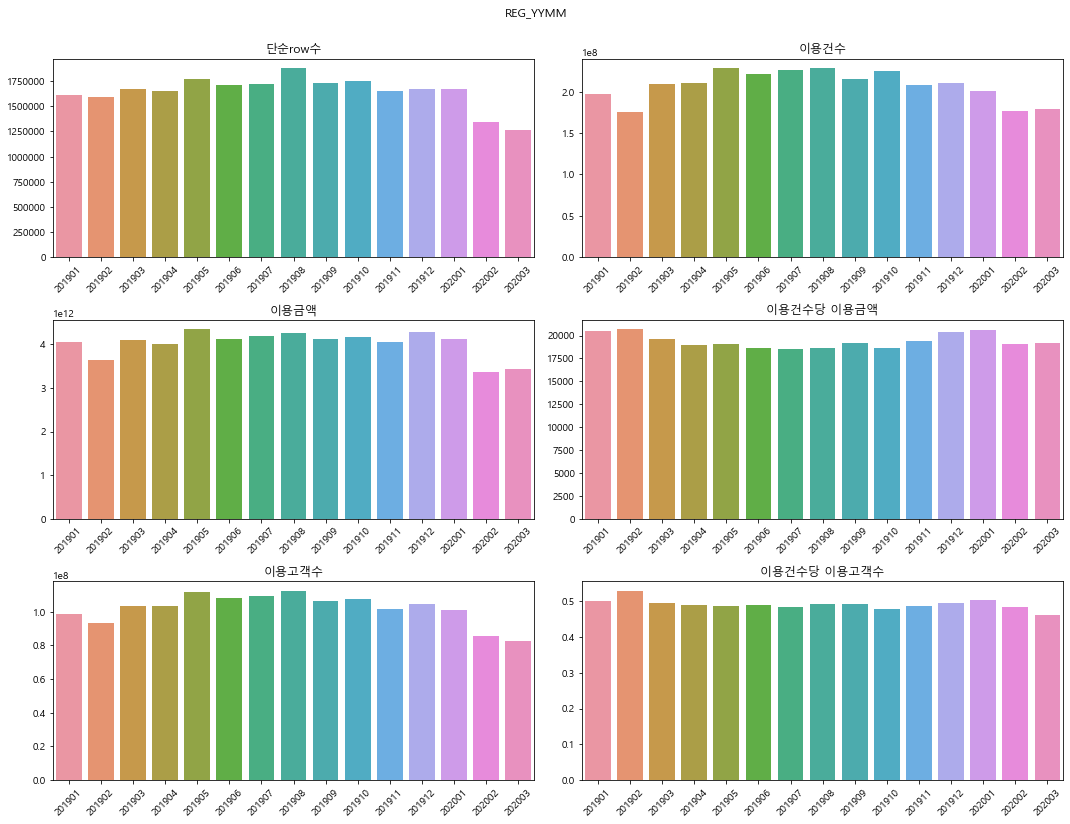

In [17]:
# 날짜
# 겨울(12,1,2)에 이용건수가 다소 감소
# 반면 이용금액 및 건당 이용금액은 더 높은편
draw_eda_graph("REG_YYMM")

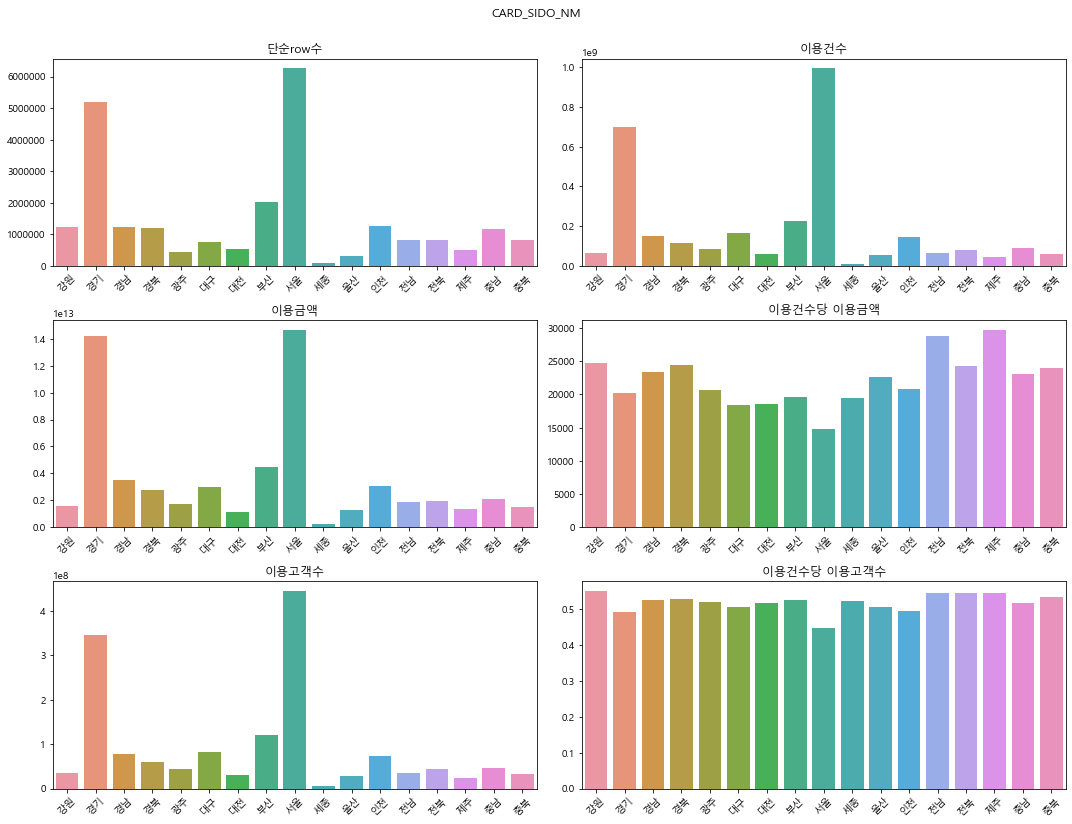

In [18]:
# 카드 이용지역시도 
# 경기서울은 이용건수대비 금액이 높은 편이 아님
# 반면 제주, 전남은 높은것으로 보아 수도권밖 여행지로 추정되는 곳의 건당 금액이 높은 것을 확인
# 서울의 경우 이용건수당 이용금액이 낮은데 환불의 경우가 꽤 있는 것으로 추정
draw_eda_graph("CARD_SIDO_NM")

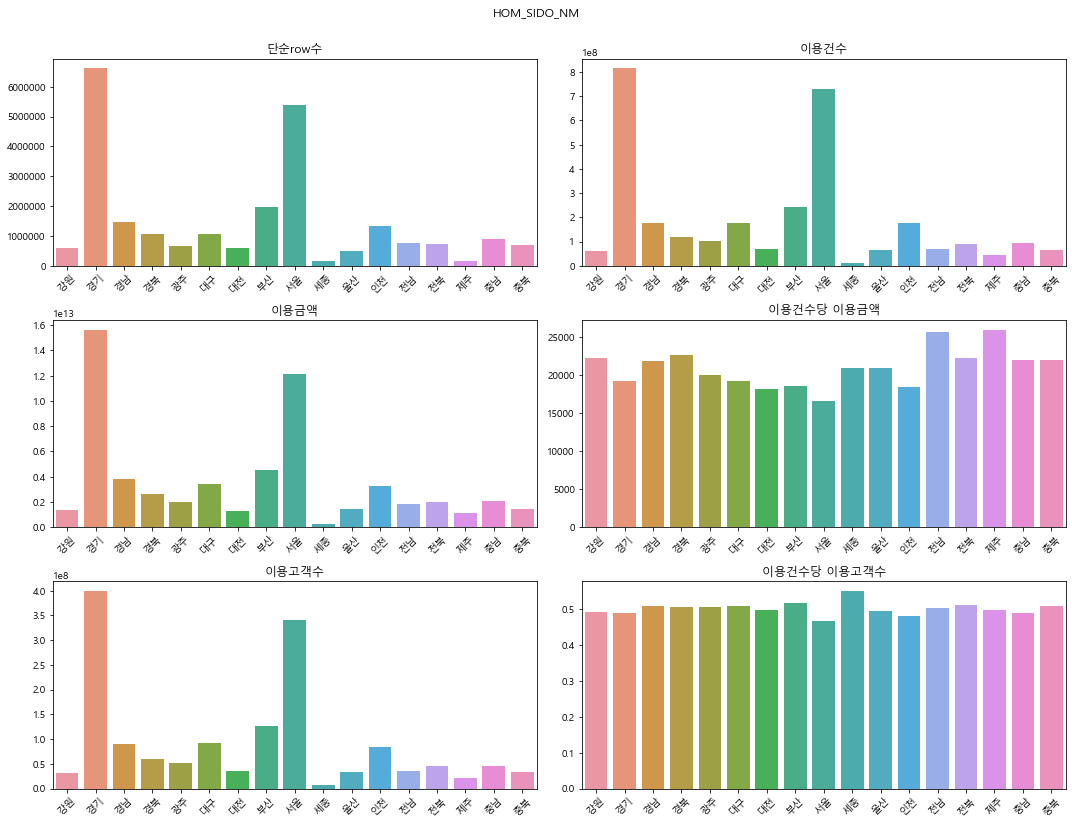

In [19]:
# 거주지역 시도
# 격기지역의 건수가 서울보다 높음
# 이용건수당 이용금액은 카드이용지역대비 전체적으로 낮은 것으로보아 거주지역외에서 이용금액이 다소 높은 것으로 추정
# 거주지역에 따른 이용건수는 큰 차이를 보이지 않음
draw_eda_graph("HOM_SIDO_NM")

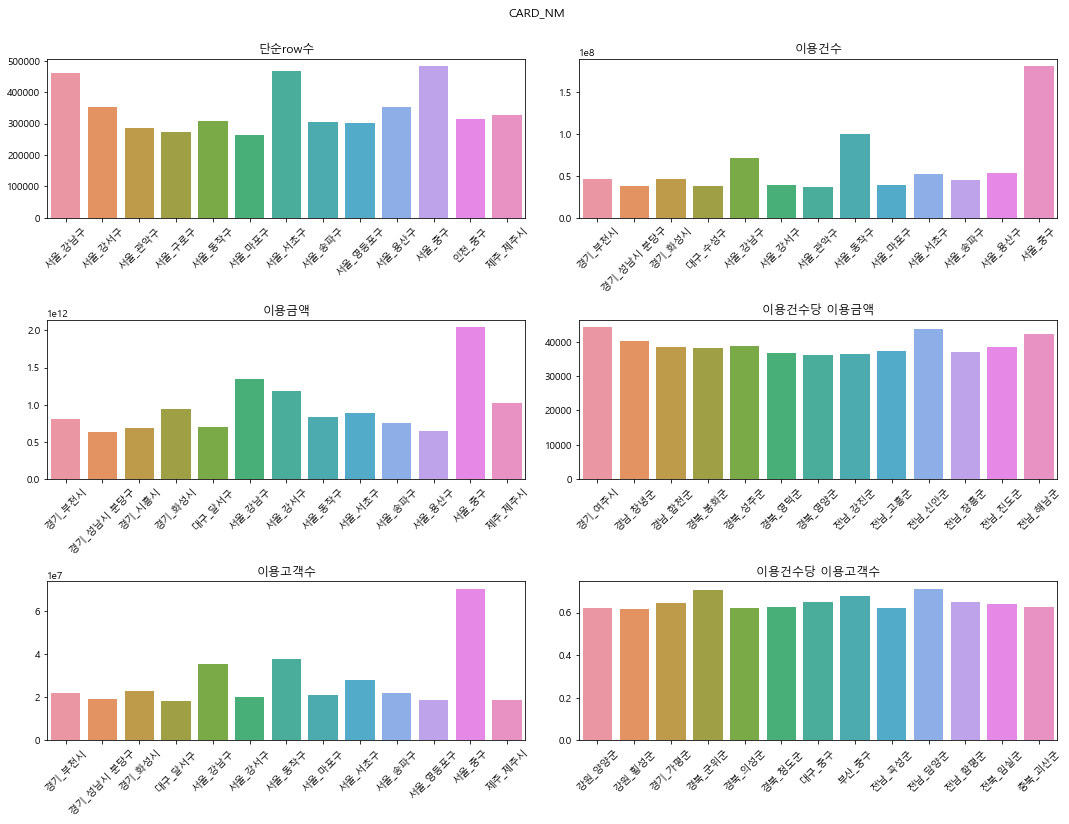

In [20]:
# 카드 이용지역 시군구
# 경기, 대구, 서울의 이용건수가 높으며 서울_중구는 압도적 
# 반면 건당 금액, 이용금액은 수도권밖아 높은편 
train['CARD_NM'] = train.CARD_SIDO_NM + "_" + train.CARD_CCG_NM
draw_eda_graph("CARD_NM",13)

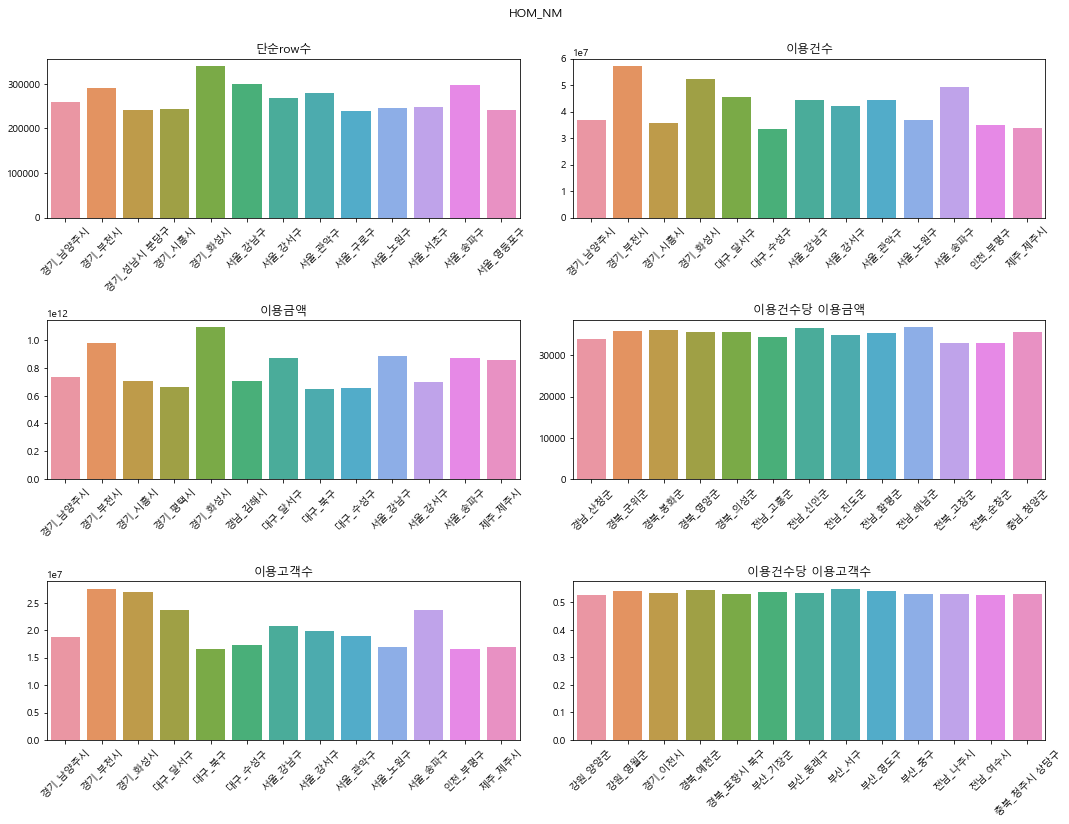

In [21]:
# 거주지역 시군구 
# 카드이용대비 중구가 크게 감소한 것으로 보아 중구의 대부분의 소비는 외지인에 의해 발생함
#
train['HOM_NM'] = train.HOM_SIDO_NM + "_" + train.HOM_CCG_NM
draw_eda_graph("HOM_NM",13)

In [22]:
#인코딩 
train, encoders = encoding(train,"STD_CLSS_NM")
job_name = encoders['STD_CLSS_NM'].inverse_transform(train.STD_CLSS_NM.unique())

job_dict = {}
for i in range(len(job_name)):
    job_dict[i]= job_name[i]

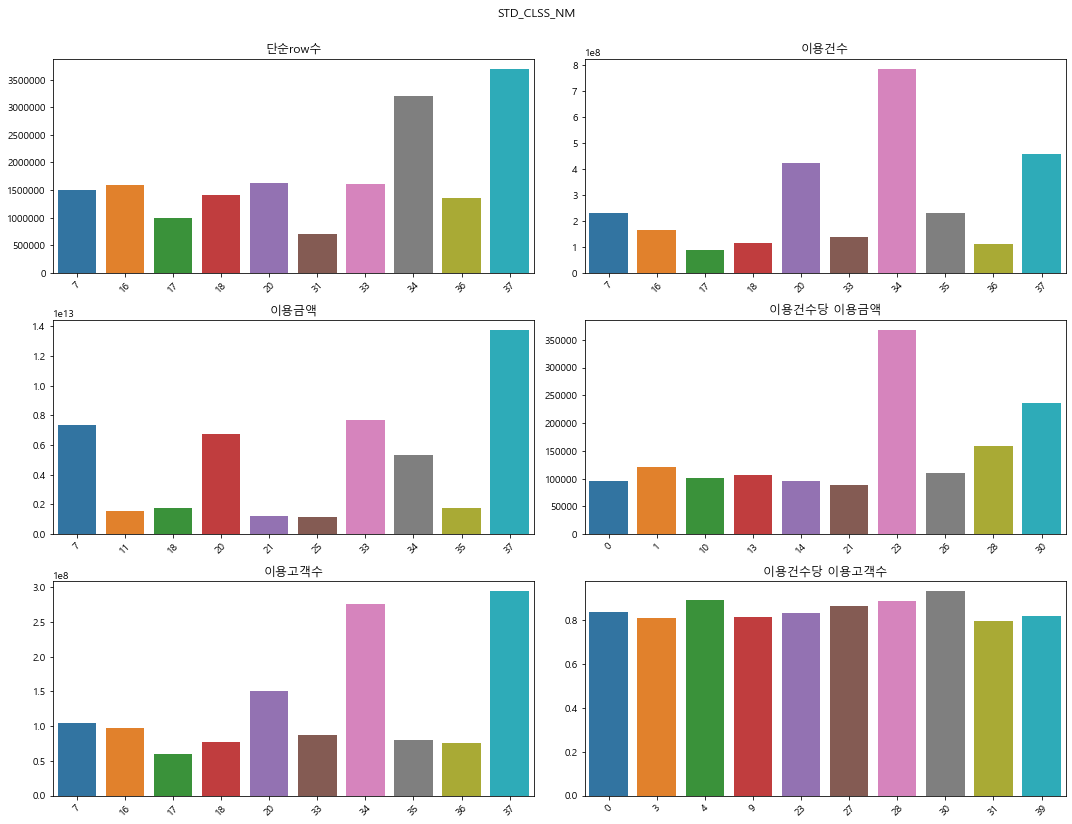

In [23]:
# 34 :면세점, 37, 기타수상오락서비스업의 건수가 높은편, 20 - 일반 유흥 주점업 또 높음 
# 건당 비용은 23 : 중식 음식점이 높고 30- 화장품 및 방향제 소매업이 높음
#
draw_eda_graph("STD_CLSS_NM",10)

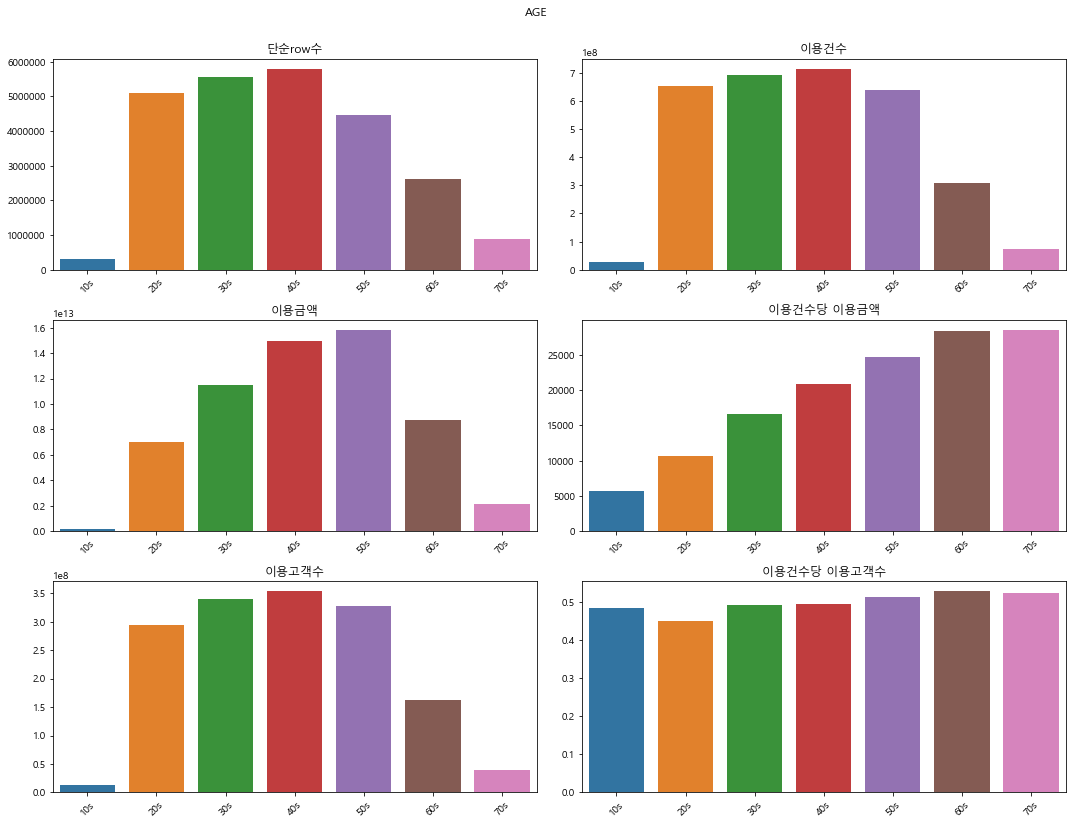

In [24]:
# 연령대 
# 20~50대의 이용건수가 높음
# 이용건수당 이용금액은 연령이 높아질수록 증가
# 20대의 이용건수당 이용금액이 다소 낮음
draw_eda_graph("AGE")

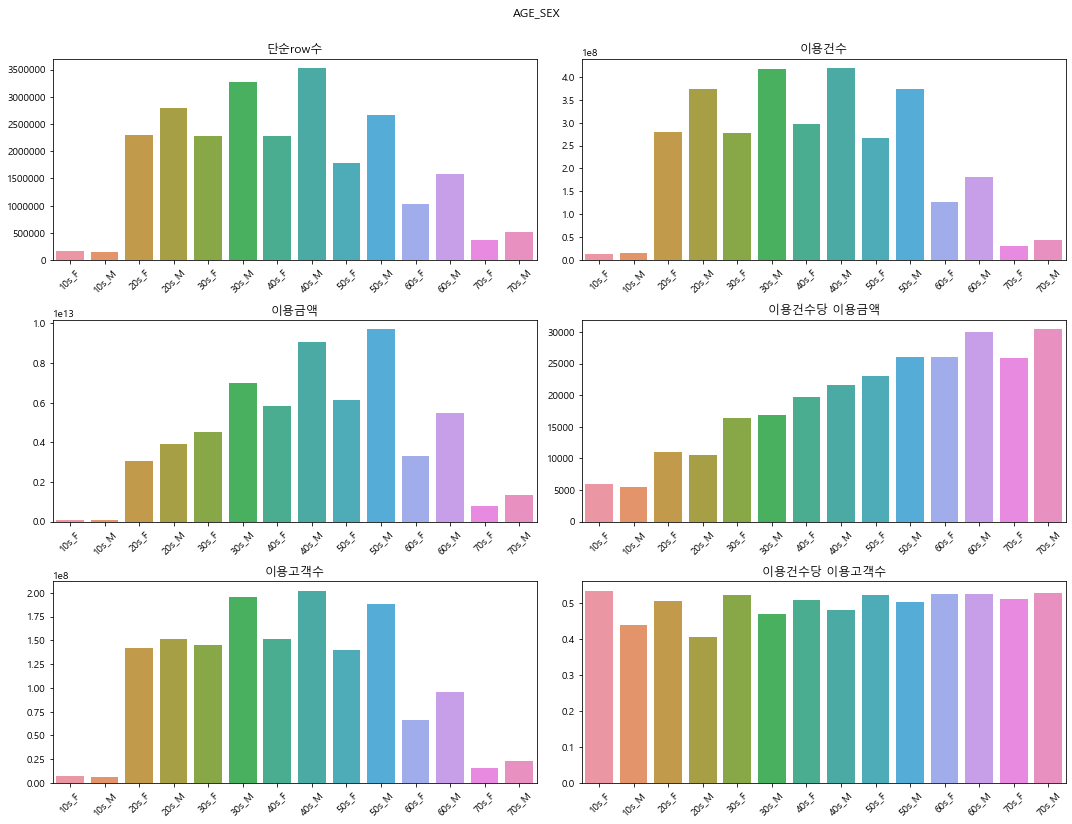

In [25]:
# 나이대_성별 
# 남성의 이용건수가 대체적으로 높음
# 10대 남성의 건당 고객수는 다소 낮은편
sex = train.SEX_CTGO_CD.apply(lambda x : "M" if x == 1  else "F")
train['AGE_SEX'] = train.AGE +'_'+ sex
draw_eda_graph('AGE_SEX',15)

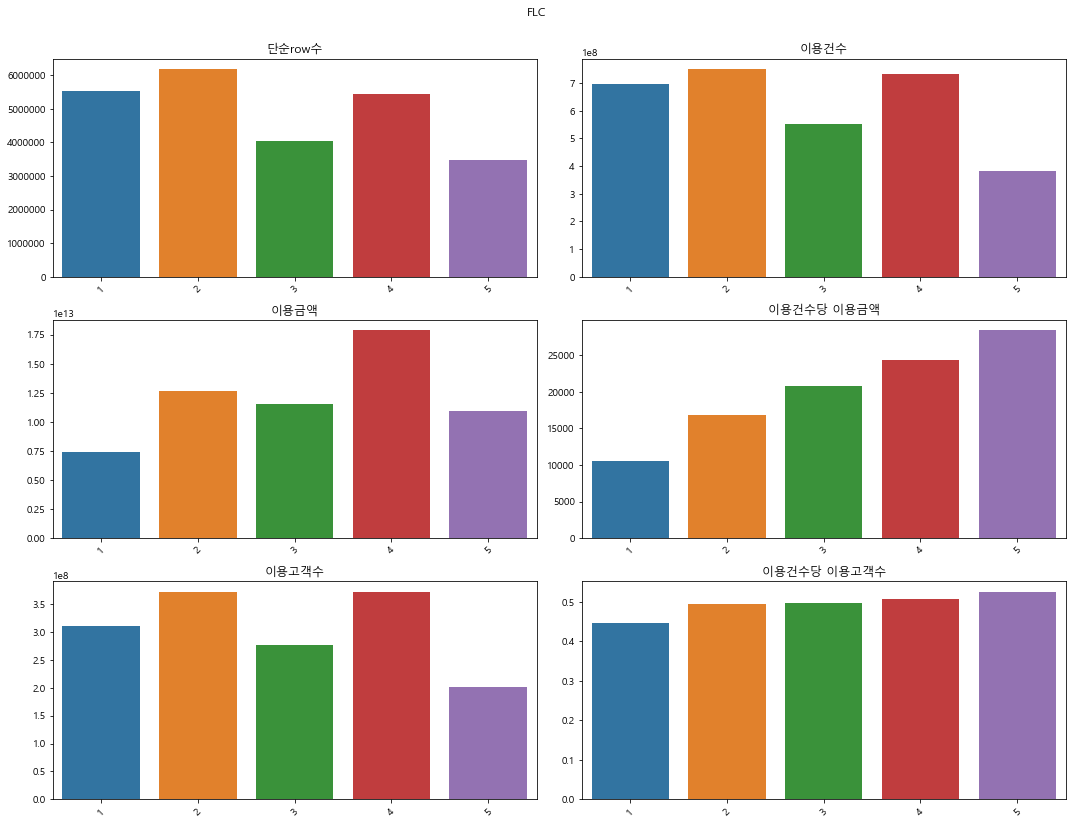

In [26]:
#가구생애주기
# 2,4번 그룹의 이용건수가 높고
# 가구생애주기가 길어질수록 건당 금액이 높음
draw_eda_graph('FLC',15)

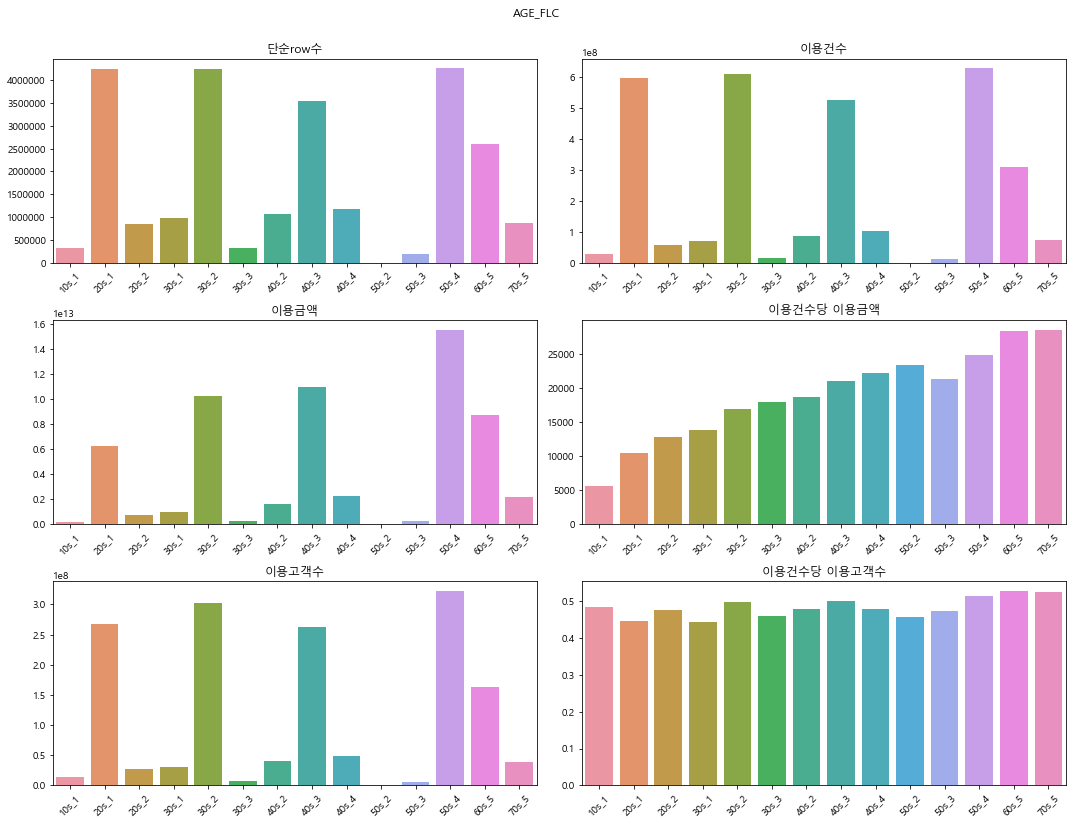

In [27]:
train['AGE_FLC'] = train.AGE +'_'+ train.FLC.astype(str)
draw_eda_graph('AGE_FLC',15)

### 보다 심화 EDA
* 20년 2-3월은 코로나가 실질적으로 시작한 기간 
 전년대비 차이는 어떻게 되는지 확인해봐야함
* 계절별 차이가 있는가 확인
* 지역별/업종별 차이 확인
 

#### 일자, 지역, 업종별로 병합
* sample 제주

In [29]:
grouped = train.groupby(['REG_YYMM',"CARD_SIDO_NM",'STD_CLSS_NM'])['AMT'].sum().reset_index()
grouped['REG_YYMM'] = pd.to_datetime(grouped.REG_YYMM,format='%Y%m')

In [30]:
jeju = grouped[grouped.CARD_SIDO_NM == '제주']
jeju.STD_CLSS_NM = encoders['STD_CLSS_NM'].inverse_transform(jeju.STD_CLSS_NM)

C:\Users\kwonJH\anaconda3\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [31]:
range_upjong = jeju.groupby('STD_CLSS_NM')['AMT'].mean().reset_index().sort_values("AMT",ascending = False)

In [32]:
range_upjong['cut'] = pd.qcut(range_upjong['AMT'],7)
range_upjong

,STD_CLSS_NM,AMT,cut
36,한식 음식점업,2.049084e+10,"(4004910284.676, 20490839253.733]"
19,슈퍼마켓,1.004799e+10,"(4004910284.676, 20490839253.733]"
32,차량용 주유소 운영업,8.864648e+09,"(4004910284.676, 20490839253.733]"
14,면세점,7.130766e+09,"(4004910284.676, 20490839253.733]"
33,체인화 편의점,6.724354e+09,"(4004910284.676, 20490839253.733]"
7,기타 대형 종합 소매업,5.207203e+09,"(4004910284.676, 20490839253.733]"
11,기타음식료품위주종합소매업,3.103191e+09,"(1954534929.6, 4004910284.676]"
29,정기 항공 운송업,2.970379e+09,"(1954534929.6, 4004910284.676]"
6,그외 기타 종합 소매업,2.372284e+09,"(1954534929.6, 4004910284.676]"
20,스포츠 및 레크레이션 용품 임대업,2.222974e+09,"(1954534929.6, 4004910284.676]"


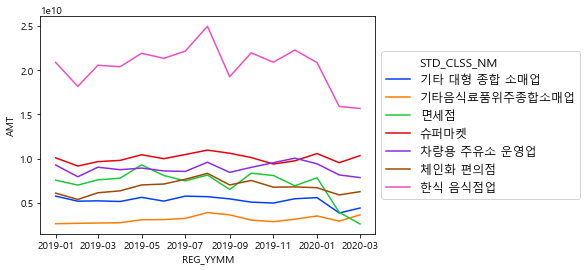

In [33]:
#평균 거래금액이 높았던 상위 7개의 경우 
#한식업, 면세점, 주유소 등은 크게 감소했으나, 슈퍼마켓, 소매업은 오히려 다소 상승세 
palette = sns.color_palette("bright",n_colors=7)
sam_col = range_upjong['STD_CLSS_NM'][:7].values
sample = jeju[jeju.STD_CLSS_NM.isin(sam_col)]
sns.lineplot(x = "REG_YYMM",y = "AMT", hue = "STD_CLSS_NM",data = sample,palette=palette)
plt.legend(loc = 'center left',bbox_to_anchor=(1, 0.5),fontsize = 12)
plt.show()

#### 제주 한식음식업에 대해서

In [34]:
train['STD_CLSS_NM'] = encoders['STD_CLSS_NM'].inverse_transform(train['STD_CLSS_NM'])
train['CNT_AMT'] = train['AMT']/train['CNT']
jeju_food = train[(train.CARD_SIDO_NM =='제주')&(train.STD_CLSS_NM == '한식 음식점업')]

In [35]:
#한식음식업은 제주시에서 이용횟수 및 금액이 더 많음 
jeju_food.groupby(['CARD_CCG_NM'])['CSTMR_CNT','AMT',"CNT",'CNT_AMT'].agg(['sum','mean'])

C:\Users\kwonJH\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


CSTMR_CNT                       AMT                    CNT  \
                  sum        mean           sum          mean      sum   
CARD_CCG_NM                                                              
서귀포시          1277959   54.824496   78340019959  3.360790e+06  1855625   
제주시           4098729  140.497343  229022568847  7.850498e+06  6296678   

                              CNT_AMT                
                   mean           sum          mean  
CARD_CCG_NM                                          
서귀포시          79.606392  1.070780e+09  45936.497783  
제주시          215.839235  1.137930e+09  39006.265630

In [36]:
# 제주 7,8,10,12월이 피크로 보임
# 건당 금액으로 보아 제주시가 서귀포시보다 금액이 저렴하다고 추측이 가능 
jeju_food.groupby(['REG_YYMM','CARD_CCG_NM'])['CSTMR_CNT','AMT',"CNT",'CNT_AMT'].agg(['sum','mean'])

C:\Users\kwonJH\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


CSTMR_CNT                      AMT                   CNT  \
                           sum        mean          sum          mean     sum   
REG_YYMM CARD_CCG_NM                                                            
201901   서귀포시            85231   52.774613   5475565259  3.390443e+06  124551   
         제주시            268311  136.823559  15415725549  7.861155e+06  413835   
201902   서귀포시            75427   49.074170   4689934883  3.051356e+06  105496   
         제주시            244616  129.221342  13485850292  7.124062e+06  360019   
201903   서귀포시            83574   52.828066   5228628704  3.305075e+06  121549   
         제주시            272523  135.921696  15343138791  7.652438e+06  419272   
201904   서귀포시            83171   53.144409   5239473928  3.347907e+06  119925   
         제주시            269536  139.007736  15161142128  7.819052e+06  412271   
201905   서귀포시            88778   56.763427   5615528228  3.590491e+06  128471   
         제주시            287289  142.011369  16308745506  8.061664e+06  442455   
201906   서귀포시            88869   55.301182   5432729028  3.380665e+06  127522   
         제주시            287733  142.653941  15920106034  7.892963e+06  437278   
201907   서귀포시            95228   58.386266   5629888482  3.451802e+06  137953   
         제주시            302049  150.497758  16537992298  8.240156e+06  459974   
201908   서귀포시           112192   61.847850   6826044069  3.762979e+06  158849   
         제주시            330955  149.213255  18162474963  8.188672e+06  498439   
201909   서귀포시            80301   52.968997   4808168289  3.171615e+06  115371   
         제주시            263180  135.940083  14459269681  7.468631e+06  400408   
201910   서귀포시            92938   54.992899   5619056471  3.324885e+06  134522   
         제주시            295854  139.487977  16357146013  7.711997e+06  459376   
201911   서귀포시            85254   52.399508   5196903956  3.194163e+06  125182   
         제주시            280933  136.973671  15712965806  7.661124e+06  436685   
201912   서귀포시            91760   55.747266   5644194693  3.429037e+06  134336   
         제주시            288740  140.369470  16647732271  8.093210e+06  445904   
202001   서귀포시            88918   53.340132   5536318709  3.321127e+06  128207   
         제주시            273150  133.897059  15338297511  7.518773e+06  418546   
202002   서귀포시            62854   53.086149   3704545338  3.128839e+06   95154   
         제주시            219632  143.832351  12193736908  7.985420e+06  346787   
202003   서귀포시            63464   59.590610   3693039922  3.467643e+06   98537   
         제주시            214228  155.462990  11978245096  8.692486e+06  345429   

                                       CNT_AMT                
                            mean           sum          mean  
REG_YYMM CARD_CCG_NM                                          
201901   서귀포시          77.121362  7.559498e+07  46808.035813  
         제주시          211.032636  7.535632e+07  38427.494788  
201902   서귀포시          68.637606  7.194030e+07  46805.660480  
         제주시          190.184363  7.228462e+07  38185.220966  
201903   서귀포시          76.832491  7.557186e+07  47769.823091  
         제주시          209.113217  7.859210e+07  39198.055481  
201904   서귀포시          76.629393  7.746341e+07  49497.386153  
         제주시          212.620423  8.110166e+07  41826.541579  
201905   서귀포시          82.142583  7.538394e+07  48199.452279  
         제주시          218.712308  7.798074e+07  38547.080755  
201906   서귀포시          79.354076  7.700957e+07  47921.323292  
         제주시          216.796232  8.259324e+07  40948.555048  
201907   서귀포시          84.581852  7.184584e+07  44050.176039  
         제주시          229.184853  7.657263e+07  38152.779158  
201908   서귀포시          87.568357  8.394098e+07  46273.969310  
         제주시          224.724527  8.667885e+07  39079.734041  
201909   서귀포시          76.102243  7.040978e+07  46444.444149  
         제주시          206.822314  7.713207e+07  39840.944673  
201910   서귀포시          7

In [37]:
#제주 현지인의 이용횟수가 월등히 높지만, 건당금액은 낮은편 
jeju_food.groupby('HOM_SIDO_NM')['CSTMR_CNT','AMT',"CNT",'CNT_AMT'].agg(['sum','mean'])

C:\Users\kwonJH\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


CSTMR_CNT                        AMT                    CNT  \
                  sum         mean           sum          mean      sum   
HOM_SIDO_NM                                                               
강원              14367    13.156593     754825784  6.912324e+05    18192   
경기             465840    35.240185   23116621447  1.748742e+06   581716   
경남              70771    22.074548    3720781299  1.160568e+06    88853   
경북              35203    17.315789    1828782178  8.995485e+05    43672   
광주              62938    35.739920    3365467693  1.911112e+06    78639   
대구              91878    36.913620    4694464796  1.886085e+06   111374   
대전              32376    23.393064    1573763433  1.137112e+06    40340   
부산             106699    23.564267    5476493615  1.209473e+06   136289   
서울             489310    46.609830   23554901591  2.243751e+06   612241   
세종               9738    30.431250     463058991  1.447059e+06    11886   
울산              27748    20.005768    1510308872  1.088903e+06    34355   
인천             106220    40.995755    5249732646  2.026142e+06   133224   
전남              26257    16.069155    1526160445  9.340027e+05    34331   
전북              33254    21.330340    1839623594  1.180002e+06    41647   
제주            3747615  2515.177852  225845231130  1.515740e+08  6116181   
충남              35559    20.518754    1743019670  1.005782e+06    43648   
충북              20915    13.415651    1099351622  7.051646e+05    25715   

                               CNT_AMT                
                    mean           sum          mean  
HOM_SIDO_NM                                           
강원             16.659341  4.827131e+07  44204.497265  
경기             44.006052  5.424109e+08  41032.670180  
경남             27.714598  1.397342e+08  43585.228598  
경북             21.481554  8.977790e+07  44160.307160  
광주             44.655877  7.741158e+07  43958.876615  
대구             44.746485  1.084409e+08  43568.074499  
대전             29.147399  5.543416e+07  40053.585564  
부산             30.099161  1.914522e+08  42281.843733  
서울             58.319775  4.328932e+08  41235.774719  
세종             37.143750  1.210706e+07  37834.573225  
울산             24.769286  6.212546e+07  44791.244970  
인천             51.417985  1.058879e+08  40867.585845  
전남             21.010404  7.457106e+07  45637.122290  
전북             26.713919  7.149190e+07  45857.537900  
제주           4104.819463  5.286478e+07  35479.717041  
충남             25.186382  7.489576e+07  43217.402696  
충북             16.494548  6.893926e+07  44220.179795

In [38]:
#일반적인 형태와 유사, 30~50대의 소비횟수 및 금액이 높음 
jeju_food.groupby('AGE')['CSTMR_CNT','AMT',"CNT",'CNT_AMT'].agg(['sum','mean'])

C:\Users\kwonJH\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


CSTMR_CNT                      AMT                    CNT              \
          sum        mean          sum          mean      sum        mean   
AGE                                                                         
10s     14898   38.696104    354979596  9.220249e+05    22166   57.574026   
20s    752874   70.838728  32306819740  3.039784e+06  1100193  103.518348   
30s   1196184  103.235005  59440342230  5.129916e+06  1713898  147.915595   
40s   1350847  103.267869  80783804665  6.175660e+06  2095610  160.202584   
50s   1350021  142.497467  87426283642  9.228022e+06  2128348  224.651467   
60s    577089   91.528787  38473436427  6.102052e+06   887127  140.702141   
70s    134775  131.744868   8576922506  8.384088e+06   204961  200.352884   

          CNT_AMT                
              sum          mean  
AGE                              
10s  4.312318e+06  11200.826703  
20s  3.298319e+08  31034.244315  
30s  4.309198e+08  37189.935817  
40s  5.852092e+08  44737.346241  
50s  4.690757e+08  49511.892897  
60s  3.341940e+08  53004.594397  
70s  5.516663e+07  53926.324744

In [39]:
jeju_food.groupby('SEX_CTGO_CD')['CSTMR_CNT','AMT',"CNT",'CNT_AMT'].agg(['sum','mean'])

C:\Users\kwonJH\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


CSTMR_CNT                       AMT                    CNT  \
                  sum        mean           sum          mean      sum   
SEX_CTGO_CD                                                              
1             3196584  111.674958  198890700240  6.948389e+06  5046194   
2             2180104   91.374492  108471888566  4.546372e+06  3106109   

                              CNT_AMT                
                   mean           sum          mean  
SEX_CTGO_CD                                          
1            176.292412  1.243473e+09  43441.615134  
2            130.186051  9.652368e+08  40455.876565

In [40]:
# 10, 20대여성의 이용횟수가 높으나, 10,20대 남성의 이용금액이 더 높은 편
# 전체를 대상으로 봤들때와는 다소 다른 결과
jeju_food['age_sex'] = jeju_food.AGE +"_"+jeju_food.SEX_CTGO_CD.astype(str)
jeju_food.groupby('age_sex')['CSTMR_CNT','AMT',"CNT",'CNT_AMT'].agg(['sum','mean'])

C:\Users\kwonJH\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\kwonJH\anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.


CSTMR_CNT                      AMT                    CNT              \
              sum        mean          sum          mean      sum        mean   
age_sex                                                                         
10s_1        7213   34.347619    180149147  8.578531e+05    10787   51.366667   
10s_2        7685   43.914286    174830449  9.990311e+05    11379   65.022857   
20s_1      351745   70.264682  16512494529  3.298541e+06   534848  106.841390   
20s_2      401129   71.349875  15794325211  2.809378e+06   565345  100.559409   
30s_1      666711  108.815244  35497016261  5.793539e+06   984394  160.664926   
30s_2      529473   96.973077  23943325969  4.385225e+06   729504  133.608791   
40s_1      821732  108.925239  52726230888  6.989161e+06  1309886  173.632821   
40s_2      529115   95.559870  28057573777  5.067288e+06   785724  141.904280   
50s_1      858097  163.602860  59722697886  1.138660e+07  1418586  270.464442   
50s_2      491924  116.321589  27703585756  6.550860e+06   709762  167.832112   
60s_1      393874  103.487651  27821989175  7.310034e+06   633775  166.519968   
60s_2      183215   73.315326  10651447252  4.262284e+06   253352  101.381353   
70s_1       97212  141.708455   6430122354  9.373356e+06   153918  224.370262   
70s_2       37563  111.462908   2146800152  6.370327e+06    51043  151.462908   

              CNT_AMT                
                  sum          mean  
age_sex                              
10s_1    2.261480e+06  10768.950595  
10s_2    2.050839e+06  11719.078033  
20s_1    1.605332e+08  32068.155332  
20s_2    1.692988e+08  30113.618461  
30s_1    2.340665e+08  38202.457613  
30s_2    1.968533e+08  36053.723172  
40s_1    3.448338e+08  45709.673358  
40s_2    2.403755e+08  43412.579080  
50s_1    2.633178e+08  50203.579336  
50s_2    2.057579e+08  48654.031613  
60s_1    2.020843e+08  53096.251734  
60s_2    1.321096e+08  52864.999429  
70s_1    3.637579e+07  53025.925735  
70s_2    1.879085e+07  55759.184449

In [41]:
#가구형태는 연령대와 굉장히 유사한 형태
jeju_food.groupby('FLC')['CSTMR_CNT','AMT',"CNT",'CNT_AMT'].agg(['sum','mean'])

C:\Users\kwonJH\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


CSTMR_CNT                      AMT                    CNT              \
          sum        mean          sum          mean      sum        mean   
FLC                                                                         
1      727478   65.847031  30763399841  2.784522e+06  1055871   95.571235   
2     1441000  104.284267  73081496544  5.288862e+06  2102053  152.124258   
3      980969  109.986433  58349470672  6.542154e+06  1501281  168.323915   
4     1515377  133.278540  98117862816  8.629539e+06  2401010  211.170624   
5      711864   97.143013  47050358933  6.420628e+06  1092088  149.029476   

          CNT_AMT                
              sum          mean  
FLC                              
1    3.396785e+08  30745.704804  
2    5.210566e+08  37708.537874  
3    4.036400e+08  45256.199924  
4    5.549738e+08  48810.359062  
5    3.893606e+08  53133.269362

In [42]:
jeju_food['age_flc'] = jeju_food.AGE +"_"+jeju_food.FLC.astype(str)
jeju_food.groupby('age_flc')['CSTMR_CNT','AMT',"CNT",'CNT_AMT'].agg(['sum','mean'])

C:\Users\kwonJH\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\kwonJH\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


CSTMR_CNT                      AMT                    CNT              \
              sum        mean          sum          mean      sum        mean   
age_flc                                                                         
10s_1       14898   38.696104    354979596  9.220249e+05    22166   57.574026   
20s_1      663173   77.983655  27952092883  3.286935e+06   959953  112.882526   
20s_2       89701   42.232109   4354726857  2.050248e+06   140240   66.026365   
30s_1       49407   22.884206   2456327362  1.137715e+06    73752   34.160259   
30s_2     1131396  124.466007  56136998680  6.175687e+06  1616005  177.778328   
30s_3       15381   45.505917    847016188  2.505965e+06    24141   71.423077   
40s_2      219903   84.448157  12589771007  4.834781e+06   345808  132.798771   
40s_3      943270  114.739083  56069340173  6.820258e+06  1439772  175.133439   
40s_4      187674   83.188830  12124693485  5.374421e+06   310030  137.424645   
50s_3       22318   61.994444   1433114311  3.980873e+06    37368  103.800000   
50s_4     1327703  145.677310  85993169331  9.435283e+06  2090980  229.425060   
60s_5      577089   91.528787  38473436427  6.102052e+06   887127  140.702141   
70s_5      134775  131.744868   8576922506  8.384088e+06   204961  200.352884   

              CNT_AMT                
                  sum          mean  
age_flc                              
10s_1    4.312318e+06  11200.826703  
20s_1    2.634981e+08  30985.198741  
20s_2    6.633382e+07  31230.611338  
30s_1    7.186810e+07  33287.678693  
30s_2    3.464451e+08  38112.769043  
30s_3    1.260662e+07  37297.684669  
40s_2    1.082777e+08  41581.293111  
40s_3    3.753213e+08  45653.974200  
40s_4    1.016102e+08  45039.989816  
50s_3    1.571211e+07  43644.743906  
50s_4    4.533636e+08  49743.643351  
60s_5    3.341940e+08  53004.594397  
70s_5    5.516663e+07  53926.324744

In [43]:
#20대 여성중 영유아가구의 경우 거래금액이 높음
#50대 중고생자녀가구의 경우 남여, 평균건당금액의 차가 가장 높음 
#50대 중고생자녀가구 여성은 거래건수가 높고, 총 거래금액이 높음
sex = jeju_food.SEX_CTGO_CD.apply(lambda x : "M" if x==1 else "F")
jeju_food['age_flc_sex'] = jeju_food.AGE +"_"+jeju_food.FLC.astype(str) +"_" + sex
jeju_food.groupby('age_flc_sex')['CSTMR_CNT','AMT',"CNT",'CNT_AMT'].agg(['sum','mean'])

C:\Users\kwonJH\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\kwonJH\anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


CSTMR_CNT                      AMT                    CNT  \
                  sum        mean          sum          mean      sum   
age_flc_sex                                                             
10s_1_F          7685   43.914286    174830449  9.990311e+05    11379   
10s_1_M          7213   34.347619    180149147  8.578531e+05    10787   
20s_1_F        346108   83.039347  13371751487  3.208194e+06   483564   
20s_1_M        317065   73.123847  14580341396  3.362625e+06   476389   
20s_2_F         55021   37.841128   2422573724  1.666144e+06    81781   
20s_2_M         34680   51.761194   1932153133  2.883811e+06    58459   
30s_1_F         16711   18.734305    762446699  8.547609e+05    23704   
30s_1_M         32696   25.805841   1693880663  1.336922e+06    50048   
30s_2_F        506855  114.776947  22889666083  5.183348e+06   696844   
30s_2_M        624541  133.620240  33247332597  7.113250e+06   919161   
30s_3_F          5907   38.861842    291213187  1.915876e+06     8956   
30s_3_M          9474   50.935484    555803001  2.988188e+06    15185   
40s_2_F         81619   95.127040   4170271887  4.860457e+06   124062   
40s_2_M        138284   79.200458   8419499120  4.822164e+06   221746   
40s_3_F        386262   98.536224  20503864511  5.230578e+06   567606   
40s_3_M        557008  129.506626  35565475662  8.269118e+06   872166   
40s_4_F         61234   80.677207   3383437379  4.457757e+06    94056   
40s_4_M        126440   84.462258   8741256106  5.839182e+06   215974   
50s_3_F          9921  150.318182    571722943  8.662469e+06    16330   
50s_3_M         12397   42.166667    861391368  2.929903e+06    21038   
50s_4_F        482003  115.782609  27131862813  6.517382e+06   693432   
50s_4_M        845700  170.813977  58861306518  1.188877e+07  1397548   
60s_5_F        183215   73.315326  10651447252  4.262284e+06   253352   
60s_5_M        393874  103.487651  27821989175  7.310034e+06   633775   
70s_5_F         37563  111.462908   2146800152  6.370327e+06    51043   
70s_5_M         97212  141.708455   6430122354  9.373356e+06   153918   

                              CNT_AMT                
                   mean           sum          mean  
age_flc_sex                                          
10s_1_F       65.022857  2.050839e+06  11719.078033  
10s_1_M       51.366667  2.261480e+06  10768.950595  
20s_1_F      116.018234  1.246146e+08  29897.937719  
20s_1_M      109.868312  1.388835e+08  32030.333414  
20s_2_F       56.245530  4.468416e+07  30731.883476  
20s_2_M       87.252239  2.164966e+07  32312.925236  
30s_1_F       26.573991  2.863652e+07  32103.725030  
30s_1_M       39.501184  4.323158e+07  34121.211974  
30s_2_F      157.799819  1.627777e+08  36860.890998  
30s_2_M      196.654044  1.836674e+08  39295.544705  
30s_3_F       58.921053  5.439111e+06  35783.625955  
30s_3_M       81.639785  7.167506e+06  38534.979963  
40s_2_F      144.594406  3.429691e+07  39973.089001  
40s_2_M      127.002291  7.398078e+07  42371.578979  
40s_3_F      144.797449  1.747876e+08  44588.661249  
40s_3_M      202.782144  2.005338e+08  46624.917415  
40s_4_F      123.920949  3.129099e+07  41226.598034  
40s_4_M      144.271209  7.031923e+07  46973.432944  
50s_3_F      247.424242  2.281451e+06  34567.436633  
50s_3_M       71.557823  1.343066e+07  45682.506763  
50s_4_F      166.570262  2.034764e+08  48877.359807  
50s_4_M      282.275904  2.498871e+08  50472.049410  
60s_5_F      101.381353  1.321096e+08  52864.999429  
60s_5_M      166.519968  2.020843e+08  53096.251734  
70s_5_F      151.462908  1.879085e+07  55759.184449  
70s_5_M      224.370262  3.637579e+07  53025.925735

In [44]:
#50대 중고생자녀가구의 경우 남여, 평균건당금액의 차가 가장 높음 
#50대 중고생자녀가구 여성은 거래건수가 높고, 총 거래금액이 높음
#지역추가

In [45]:
jeju_food['hom_age_flc_sex'] = jeju_food.HOM_SIDO_NM +"_"+jeju_food['age_flc_sex']
jeju_food.groupby('hom_age_flc_sex')['CSTMR_CNT','AMT',"CNT",'CNT_AMT'].agg(['sum','mean'])

C:\Users\kwonJH\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\kwonJH\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


CSTMR_CNT                   AMT                 CNT  \
                      sum       mean        sum          mean   sum   
hom_age_flc_sex                                                       
강원_10s_1_F              3   3.000000      17000  1.700000e+04     4   
강원_10s_1_M              6   3.000000     150000  7.500000e+04     6   
강원_20s_1_F           1448  16.269663   49743332  5.589138e+05  1800   
강원_20s_1_M           1553  13.387931   64336040  5.546210e+05  1966   
강원_20s_2_F            117   7.312500    4104700  2.565438e+05   141   
...                   ...        ...        ...           ...   ...   
충북_50s_4_F           1781  11.794702  107037510  7.088577e+05  2073   
충북_50s_4_M           3219  16.340102  213217300  1.082321e+06  4239   
충북_60s_5_F            211   4.395833   13986500  2.913854e+05   265   
충북_60s_5_M            742   6.684685   47763770  4.303042e+05   927   
충북_70s_5_M             23   3.285714    1225500  1.750714e+05    31   

                                 CNT_AMT                
                      mean           sum          mean  
hom_age_flc_sex                                         
강원_10s_1_F        4.000000  4.250000e+03   4250.000000  
강원_10s_1_M        3.000000  5.000000e+04  25000.000000  
강원_20s_1_F       20.224719  2.543165e+06  28574.886230  
강원_20s_1_M       16.948276  3.724968e+06  32111.795807  
강원_20s_2_F        8.812500  5.136810e+05  32105.059420  
...                    ...           ...           ...  
충북_50s_4_F       13.728477  8.121890e+06  53787.347927  
충북_50s_4_M       21.517766  1.072580e+07  54445.704518  
충북_60s_5_F        5.520833  2.808081e+06  58501.695475  
충북_60s_5_M        8.351351  5.769809e+06  51980.261033  
충북_70s_5_M        4.428571  2.691036e+05  38443.367347  

[394 rows x 8 columns]

### 코로나 이후 지역별 성장한 업종
성장한 업종과 성장하지 못한 업종을 구분해보자

In [46]:
pivoted = train.pivot_table(index = ['CARD_SIDO_NM','STD_CLSS_NM'],columns ='REG_YYMM',values= "AMT").reset_index()

In [47]:
#전체 15개중 거의 누락인 경우도 존재한다
#그럼 7월예측때도 누락 0으로 예측해야하나???
max_col = len(pivoted.iloc[:,2:].columns)

In [48]:
pivoted['na_rate'] = pivoted.iloc[:,2:].isna().sum(axis=1)/max_col
pivoted['na_count'] = pivoted.iloc[:,2:].isna().sum(axis=1)

### 전국업종과 비교

In [49]:
all_jobs_df = pd.read_csv('./data/외부데이터/18 사업체총조사_키워드매칭.csv',encoding = 'cp949')
all_jobs_df = all_jobs_df[['행정구역별','데이터업종명','사업체수 (개)', '종사자수 (명)']]
all_jobs_df.columns = ['CARD_SIDO_NM','STD_CLSS_NM', 'company','employee']
all_jobs_df.employee = all_jobs_df.employee.apply(lambda x : x.replace("X","0")).astype(int)
all_jobs_df = all_jobs_df.groupby(['CARD_SIDO_NM','STD_CLSS_NM'])[['company','employee']].sum().reset_index()

#제출파일과 비교
check_df = pd.merge(submission,all_jobs_df,left_on=['CARD_SIDO_NM','STD_CLSS_NM'],right_on=['CARD_SIDO_NM','STD_CLSS_NM'],how='left')

In [50]:
#세종에는 진짜 호텔이 없다
check_df[check_df.company.isna()]

,id,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT,company,employee
137,137,202004,경북,면세점,0,NaN,NaN
176,176,202004,광주,내항 여객 운송업,0,NaN,NaN
178,178,202004,광주,면세점,0,NaN,NaN
204,204,202004,광주,휴양콘도 운영업,0,NaN,NaN
217,217,202004,대구,내항 여객 운송업,0,NaN,NaN
245,245,202004,대구,휴양콘도 운영업,0,NaN,NaN
258,258,202004,대전,내항 여객 운송업,0,NaN,NaN
377,377,202004,세종,기타 수상오락 서비스업,0,NaN,NaN
381,381,202004,세종,내항 여객 운송업,0,NaN,NaN
383,383,202004,세종,면세점,0,NaN,NaN


In [51]:
pivoted.loc[pivoted['na_rate']>0,['CARD_SIDO_NM','STD_CLSS_NM','na_rate','na_count']].sort_values('na_rate',ascending =False).head()

REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,na_rate,na_count
4,강원,그외 기타 분류안된 오락관련 서비스업,0.933333,14
250,대전,여행사업,0.933333,14
486,전남,택시 운송업,0.933333,14
352,세종,기타 수상오락 서비스업,0.933333,14
349,세종,그외 기타 스포츠시설 운영업,0.933333,14


####  train에 있는 모든 업종은 submission에도 있는가?
지역별 몇 업종은 결측치가 많음

In [52]:
uni_sidos = train.CARD_SIDO_NM.unique()
differ_count_ls = []
differ_ls =[]
for sido in uni_sidos:
    uni_job = train[train.CARD_SIDO_NM == sido]['STD_CLSS_NM'].unique()
    uni_job_count = len(uni_job)
    sub_jobs = submission.loc[(submission.CARD_SIDO_NM == sido)&(submission.REG_YYMM == 202004),"STD_CLSS_NM"].unique()
    differ = pd.Series(sub_jobs)[~(pd.Series(sub_jobs).isin(list(uni_job)))].values
    
    differ_count_ls.append(len(differ))
    differ_ls.append(differ)

In [53]:
differ_df = pd.DataFrame(data ={'sido':uni_sidos, "counted":differ_count_ls, "differ": differ_ls})

In [54]:
#각지역별 결측인경우
differ_df

,sido,counted,differ
0,강원,1,[정기 항공 운송업]
1,경기,2,"[면세점, 정기 항공 운송업]"
2,경남,2,"[면세점, 정기 항공 운송업]"
3,경북,2,"[면세점, 정기 항공 운송업]"
4,광주,4,"[그외 기타 분류안된 오락관련 서비스업, 면세점, 정기 항공 운송업, 휴양콘도 운영업]"
5,대구,4,"[그외 기타 분류안된 오락관련 서비스업, 내항 여객 운송업, 정기 항공 운송업, 휴..."
6,대전,7,"[그외 기타 분류안된 오락관련 서비스업, 내항 여객 운송업, 면세점, 버스 운송업,..."
7,부산,1,[그외 기타 분류안된 오락관련 서비스업]
8,서울,2,"[그외 기타 분류안된 오락관련 서비스업, 휴양콘도 운영업]"
9,세종,9,"[내항 여객 운송업, 면세점, 버스 운송업, 여행사업, 자동차 임대업, 정기 항공 ..."


### 월별, 업종의 매출액 비중
각 지역별로 매출의 비중은 다소 차이가 있음  
19년 전체 평균보다는 각 월의 비중을 계산해본다

In [172]:
pivoted = train.pivot_table(index = ['CARD_SIDO_NM','CARD_CCG_NM','STD_CLSS_NM'],columns ='REG_YYMM',values= "AMT",aggfunc='sum').reset_index()
pivoted.fillna(0,inplace= True)

In [183]:
pivoted.shape

(7774, 18)

In [197]:
#각 지역별(시군구)업종의 매출비율을 저장
sidos = pivoted.CARD_SIDO_NM.unique()

local_percent_df = pd.DataFrame()
for sido in sidos:
    sample_sido = pivoted[pivoted.CARD_SIDO_NM == sido]
    sigungus = sample_sido.CARD_CCG_NM.unique()
    for sigungu in sigungus:
        sample = sample_sido[sample_sido.CARD_CCG_NM == sigungu]
        sum_arr = sample.iloc[:,3:].sum().values.reshape(1,-1)
        parcent_df = (sample.iloc[:,3:]/sum_arr)*100

        fin = pd.concat([sample.iloc[:,:3],parcent_df],axis=1)
        local_percent_df = pd.concat([local_percent_df,fin])

In [198]:
local_percent_df

REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,201901,201902,201903,201904,201905,201906,201907,201908,201909,201910,201911,201912,202001,202002,202003
0,강원,강릉시,건강보조식품 소매업,0.138432,0.168984,0.127142,0.107502,0.111191,0.097806,0.071683,0.069646,0.193419,0.100647,0.067864,0.083023,0.142702,0.079882,0.104302
1,강원,강릉시,골프장 운영업,0.148825,0.133220,0.519063,0.573575,0.702491,0.658386,0.630969,0.453584,0.455066,0.701834,0.808766,0.412113,0.117771,0.157573,0.489500
2,강원,강릉시,과실 및 채소 소매업,1.468549,1.511656,1.038271,0.726631,0.765632,0.814366,0.770445,1.109944,1.153655,1.300223,0.998961,1.065409,1.890954,1.297341,1.292833
3,강원,강릉시,관광 민예품 및 선물용품 소매업,0.022661,0.018606,0.018083,0.013991,0.018634,0.016331,0.015322,0.018189,0.016786,0.013760,0.017103,0.010337,0.015372,0.019467,0.016193
4,강원,강릉시,그외 기타 스포츠시설 운영업,0.003255,0.000212,0.001523,0.000891,0.000653,0.001314,0.003806,0.002705,0.000982,0.000000,0.003261,0.001140,0.006764,0.000655,0.011382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7769,충북,충주시,피자 햄버거 샌드위치 및 유사 음식점업,1.510620,1.509841,1.427481,1.379297,1.353079,1.435081,1.461167,1.419740,1.313521,1.248753,1.154331,1.382504,1.361553,1.438912,1.415187
7770,충북,충주시,한식 음식점업,22.763970,22.376199,22.179335,21.250023,21.316997,21.059601,21.849980,22.610869,19.507097,19.659369,19.065559,22.349371,21.210109,20.498652,16.183032
7771,충북,충주시,호텔업,0.220857,0.223202,0.179528,0.219094,0.209512,0.140687,0.123247,0.123248,0.150933,0.146053,0.210673,0.258979,0.187870,0.055388,0.097394
7772,충북,충주시,화장품 및 방향제 소매업,0.747228,0.687649,0.656473,0.659552,0.529864,0.522037,0.463975,0.421859,0.401747,0.396223,0.387596,0.419741,0.433884,0.477776,0.395545


### 전국업종비교

In [121]:
all_pivoted = train.pivot_table(index = ['STD_CLSS_NM'],columns ='REG_YYMM',values= "AMT",aggfunc= 'sum').reset_index()
all_pivoted.fillna(0,inplace= True)

In [106]:
all_pivoted.STD_CLSS_NM.unique()

array(['건강보조식품 소매업', '골프장 운영업', '과실 및 채소 소매업', '관광 민예품 및 선물용품 소매업',
       '그외 기타 분류안된 오락관련 서비스업', '그외 기타 스포츠시설 운영업', '그외 기타 종합 소매업',
       '기타 대형 종합 소매업', '기타 수상오락 서비스업', '기타 외국식 음식점업', '기타 주점업',
       '기타음식료품위주종합소매업', '내항 여객 운송업', '마사지업', '면세점', '버스 운송업', '비알콜 음료점업',
       '빵 및 과자류 소매업', '서양식 음식점업', '수산물 소매업', '슈퍼마켓', '스포츠 및 레크레이션 용품 임대업',
       '여관업', '여행사업', '욕탕업', '육류 소매업', '일반유흥 주점업', '일식 음식점업', '자동차 임대업',
       '전시 및 행사 대행업', '정기 항공 운송업', '중식 음식점업', '차량용 가스 충전업', '차량용 주유소 운영업',
       '체인화 편의점', '택시 운송업', '피자 햄버거 샌드위치 및 유사 음식점업', '한식 음식점업', '호텔업',
       '화장품 및 방향제 소매업', '휴양콘도 운영업'], dtype=object)

In [207]:
all_pivoted = all_pivoted.set_index('STD_CLSS_NM')

In [213]:
all_pivoted.loc[job]

REG_YYMM,201901,201902,201903,201904,201905,201906,201907,201908,201909,201910,201911,201912,202001,202002,202003
STD_CLSS_NM,,,,,,,,,,,,,,,
건강보조식품 소매업,8605074944,7695979668,6307887107,6189621059,7930621122,6235724774,5812021661,5825692808,9824964625,7243896123,6148728199,5831396872,10380995655,5340082879,5753676884
골프장 운영업,11968748603,16172821771,42108966385,51594105911,61560857446,60816504109,51603437320,47137504416,47971421728,60274503432,50676272989,22775041883,13414089759,18228841136,39398851940
과실 및 채소 소매업,44453112689,41217254299,38415185909,37929318326,40109803493,37596533926,34722470972,39038864865,49636213189,40381382149,41814927207,40801321529,55612798228,34708535677,42491078825
관광 민예품 및 선물용품 소매업,955750428,836063298,1018056196,1132707516,1227161510,1078516132,947813541,1209506009,888723804,1172329063,1449567937,1236188888,981629002,531651593,463741220
그외 기타 스포츠시설 운영업,305925950,261992400,231791910,146125100,179603820,198211860,180582528,242269649,159768830,148564170,116637702,178228000,232538575,107046140,42628600
그외 기타 종합 소매업,73748981612,65240336771,63325621140,61642072463,68730852590,63218879351,63769792145,67608321538,75869764181,66985561685,71679360080,70941220663,77895365413,62824829847,72210158692
기타 대형 종합 소매업,538843857358,484343025141,517323547314,494817697752,524741382417,470795799066,504817794698,491858368373,513691411678,486428371474,470729997282,508751891497,517407518399,383675206614,420628950325
기타 외국식 음식점업,45665083827,38572881680,45944677941,43459624678,43973488460,40876110018,41933644755,42239281833,40153057754,44150996235,42755563910,48215599765,41938280888,33614067688,29675319516
기타 주점업,11440224026,10215160802,11736607723,10985192625,11368165573,10940876657,11147237494,11037472786,11537691071,11155753729,10822452700,13799482514,11372122630,9202171469,7993009006


In [202]:
sigungu

'충주시'

In [211]:
job = pivoted[(pivoted.CARD_SIDO_NM == "강원")&(pivoted.CARD_CCG_NM =='강릉시')].STD_CLSS_NM.values

In [107]:
jobs = ganwon_pivot.STD_CLSS_NM.values

In [118]:
all_pivoted[all_pivoted.STD_CLSS_NM == jobs[0]].iloc[:,1:]

REG_YYMM,201901,201902,201903,201904,201905,201906,201907,201908,201909,201910,201911,201912,202001,202002,202003
0,1.430841e+06,1.358753e+06,1.120008e+06,1.101944e+06,1.292474e+06,1.122139e+06,1.054622e+06,1.071096e+06,1.527038e+06,1.168370e+06,1.126141e+06,1.124016e+06,1.684680e+06,1.205981e+06,1.303211e+06


In [119]:
ganwon_pivot[ganwon_pivot.STD_CLSS_NM == jobs[0]].iloc[:,2:]

REG_YYMM,201901,201902,201903,201904,201905,201906,201907,201908,201909,201910,201911,201912,202001,202002,202003
0,1.578242e+06,1.410730e+06,1.272547e+06,1.024505e+06,1.371442e+06,1.009898e+06,953667.329897,1.076338e+06,1.616958e+06,1.007980e+06,971135.059406,1.046509e+06,1.697328e+06,1.033859e+06,1.185914e+06


In [117]:
ganwon_pivot[ganwon_pivot.STD_CLSS_NM == jobs[0]].iloc[:,2:]/ all_pivoted[all_pivoted.STD_CLSS_NM == jobs[0]].iloc[:,1:]

REG_YYMM,201901,201902,201903,201904,201905,201906,201907,201908,201909,201910,201911,201912,202001,202002,202003
0,1.103017,1.038253,1.136194,0.929724,1.061098,0.899976,0.904274,1.004894,1.058885,0.862723,0.862357,0.931044,1.007508,0.857276,0.909994


In [102]:
ganwon_pivot.STD_CLSS_NM.unique()

array(['건강보조식품 소매업', '골프장 운영업', '과실 및 채소 소매업', '관광 민예품 및 선물용품 소매업',
       '그외 기타 분류안된 오락관련 서비스업', '그외 기타 스포츠시설 운영업', '그외 기타 종합 소매업',
       '기타 대형 종합 소매업', '기타 수상오락 서비스업', '기타 외국식 음식점업', '기타 주점업',
       '기타음식료품위주종합소매업', '내항 여객 운송업', '마사지업', '면세점', '버스 운송업', '비알콜 음료점업',
       '빵 및 과자류 소매업', '서양식 음식점업', '수산물 소매업', '슈퍼마켓', '스포츠 및 레크레이션 용품 임대업',
       '여관업', '여행사업', '욕탕업', '육류 소매업', '일반유흥 주점업', '일식 음식점업', '자동차 임대업',
       '전시 및 행사 대행업', '중식 음식점업', '차량용 가스 충전업', '차량용 주유소 운영업', '체인화 편의점',
       '택시 운송업', '피자 햄버거 샌드위치 및 유사 음식점업', '한식 음식점업', '호텔업',
       '화장품 및 방향제 소매업', '휴양콘도 운영업'], dtype=object)

### 업종별 매출비교

In [61]:
job_pivot= train.pivot_table(index='STD_CLSS_NM',columns= "REG_YYMM",values= 'AMT',aggfunc ='sum').reset_index()

In [62]:
job_pivot['mean'] = job_pivot.iloc[:,1:].mean(axis=1)

In [63]:
#전국 평균
job_pivot[['STD_CLSS_NM','mean']].sort_values('mean',ascending= False).head()

REG_YYMM,STD_CLSS_NM,mean
37,한식 음식점업,9.158326e+11
33,차량용 주유소 운영업,5.139101e+11
7,기타 대형 종합 소매업,4.885903e+11
20,슈퍼마켓,4.486886e+11
34,체인화 편의점,3.535972e+11


In [64]:
#전국 평균
job_pivot[['STD_CLSS_NM','mean']].sort_values('mean',ascending= False).tail()

REG_YYMM,STD_CLSS_NM,mean
13,마사지업,1.346659e+09
3,관광 민예품 및 선물용품 소매업,1.008627e+09
5,그외 기타 스포츠시설 운영업,1.821277e+08
8,기타 수상오락 서비스업,1.114206e+08
4,그외 기타 분류안된 오락관련 서비스업,2.483099e+06


In [65]:
# 코로나 이후 상승한 업종, 19년 대비 가격 상승
# 소매업종 계열이 상승, 주유소?? 의아함
up_amount = pivoted[((pivoted[202002]- pivoted[201902])>0)&((pivoted[202003]- pivoted[201903])>0)]

In [66]:
up_amount.STD_CLSS_NM.value_counts()

체인화 편의점                  17
슈퍼마켓                     17
기타음식료품위주종합소매업            16
피자 햄버거 샌드위치 및 유사 음식점업    16
빵 및 과자류 소매업              16
차량용 주유소 운영업              15
비알콜 음료점업                 14
기타 대형 종합 소매업             12
차량용 가스 충전업               10
그외 기타 종합 소매업             10
골프장 운영업                   9
한식 음식점업                   8
욕탕업                       7
여관업                       7
중식 음식점업                   5
관광 민예품 및 선물용품 소매업         5
서양식 음식점업                  5
화장품 및 방향제 소매업             4
과실 및 채소 소매업               4
자동차 임대업                   4
수산물 소매업                   3
휴양콘도 운영업                  3
그외 기타 스포츠시설 운영업           3
택시 운송업                    3
건강보조식품 소매업                2
버스 운송업                    2
여행사업                      2
내항 여객 운송업                 2
그외 기타 분류안된 오락관련 서비스업      2
호텔업                       2
기타 수상오락 서비스업              2
일반유흥 주점업                  2
기타 외국식 음식점업               2
기타 주점업                    1
마사지업                      1
육류 소매업              

In [67]:
# 코로나 이후 하락한 업종, 19년 대비 가격 하락
# 야외활동, 단체활동, 음식점 관련이 감소
down_amount = pivoted[((pivoted[202002]- pivoted[201902])<0)&((pivoted[202003]- pivoted[201903])<0)]

In [68]:
down_amount.STD_CLSS_NM.value_counts()

스포츠 및 레크레이션 용품 임대업    16
기타 외국식 음식점업           14
전시 및 행사 대행업           12
마사지업                  12
그외 기타 스포츠시설 운영업       12
일반유흥 주점업              12
일식 음식점업               11
화장품 및 방향제 소매업          9
욕탕업                    9
기타 주점업                 9
기타 수상오락 서비스업           8
호텔업                    8
면세점                    7
중식 음식점업                7
자동차 임대업                6
여행사업                   6
휴양콘도 운영업               6
정기 항공 운송업              6
건강보조식품 소매업             6
내항 여객 운송업              6
서양식 음식점업               5
여관업                    5
버스 운송업                 5
관광 민예품 및 선물용품 소매업      5
골프장 운영업                4
과실 및 채소 소매업            3
택시 운송업                 3
수산물 소매업                3
한식 음식점업                1
차량용 가스 충전업             1
그외 기타 종합 소매업           1
기타 대형 종합 소매업           1
Name: STD_CLSS_NM, dtype: int64

#### 지역별코로나 후  매출 상위, 하위업종

In [69]:
train.STD_CLSS_NM.unique()

array(['건강보조식품 소매업', '골프장 운영업', '과실 및 채소 소매업', '관광 민예품 및 선물용품 소매업',
       '그외 기타 스포츠시설 운영업', '그외 기타 종합 소매업', '기타 대형 종합 소매업', '기타 외국식 음식점업',
       '기타 주점업', '기타음식료품위주종합소매업', '마사지업', '비알콜 음료점업', '빵 및 과자류 소매업',
       '서양식 음식점업', '수산물 소매업', '슈퍼마켓', '스포츠 및 레크레이션 용품 임대업', '여관업', '욕탕업',
       '육류 소매업', '일반유흥 주점업', '일식 음식점업', '전시 및 행사 대행업', '중식 음식점업',
       '차량용 가스 충전업', '차량용 주유소 운영업', '체인화 편의점', '피자 햄버거 샌드위치 및 유사 음식점업',
       '한식 음식점업', '호텔업', '화장품 및 방향제 소매업', '휴양콘도 운영업', '여행사업', '자동차 임대업',
       '면세점', '버스 운송업', '택시 운송업', '기타 수상오락 서비스업', '내항 여객 운송업',
       '그외 기타 분류안된 오락관련 서비스업', '정기 항공 운송업'], dtype=object)

In [70]:
pivoted['02_gap'] = pivoted[202002] - pivoted[201902]
pivoted['03_gap'] = pivoted[202003] - pivoted[201903]
pivoted['sum_both'] = pivoted['02_gap'] + pivoted['03_gap']

In [71]:
uni_sidos = pivoted.CARD_SIDO_NM.unique()
sidos = []
top5_jobs = []
top5_amounts = []
last5_jobs = []
last5_amounts = []
for sido in uni_sidos:
    target = pivoted.loc[pivoted['CARD_SIDO_NM'] == sido].sort_values('sum_both',ascending = False)
    target = target.loc[target.sum_both.dropna().index] #비교가 안되는 NaN 업종은 제외
    top5_job = target.head(5)['STD_CLSS_NM'].values
    top5_amount = target.head(5)['sum_both'].values

    last5_job = target.tail(5)['STD_CLSS_NM'].values
    last5_amount = target.tail(5)['sum_both'].values
    sidos.append(sido)
    top5_jobs.append(list(top5_job))
    top5_amounts.append(list(top5_amount))
    last5_jobs.append(list(reversed(last5_job)))
    last5_amounts.append(list(reversed(last5_amount)))

In [72]:
sido_df= pd.DataFrame({'sido': sidos})

In [73]:
cols = []
for i in range(1,6):
    cols.append('top_job'+str(i))

top5_df = pd.DataFrame(top5_jobs,columns = cols)

In [74]:
cols = []
for i in range(1,6):
    cols.append('top_amount'+str(i))

top5_df = pd.DataFrame(top5_amounts,columns = cols)

In [75]:
cols = []
for i in range(1,6):
    cols.append('last_job'+str(i))

last5_df = pd.DataFrame(last5_jobs,columns = cols)

In [76]:
sido_df = pd.concat([sido_df,top5_df],axis=1)
sido_df = pd.concat([sido_df,last5_df],axis=1)

In [77]:
sido_df

,sido,top_amount1,top_amount2,top_amount3,top_amount4,top_amount5,last_job1,last_job2,last_job3,last_job4,last_job5
0,강원,1.466792e+06,1.292672e+06,1.282844e+06,1.086480e+06,8.584709e+05,마사지업,건강보조식품 소매업,기타 주점업,육류 소매업,스포츠 및 레크레이션 용품 임대업
1,경기,2.691460e+06,1.129798e+06,1.039945e+06,1.015550e+06,8.476935e+05,호텔업,그외 기타 종합 소매업,일반유흥 주점업,마사지업,전시 및 행사 대행업
2,경남,2.197943e+06,2.035053e+06,1.608112e+06,9.871109e+05,8.673771e+05,여행사업,스포츠 및 레크레이션 용품 임대업,일반유흥 주점업,호텔업,일식 음식점업
3,경북,4.703614e+06,2.299472e+06,1.906429e+06,1.798212e+06,1.039064e+06,스포츠 및 레크레이션 용품 임대업,일반유흥 주점업,기타 외국식 음식점업,일식 음식점업,기타 주점업
4,광주,7.130083e+06,3.582946e+06,2.447411e+06,2.363559e+06,1.505377e+06,스포츠 및 레크레이션 용품 임대업,내항 여객 운송업,호텔업,과실 및 채소 소매업,자동차 임대업
5,대구,1.140989e+07,2.611430e+06,2.569849e+06,2.399242e+06,1.538777e+06,스포츠 및 레크레이션 용품 임대업,면세점,일반유흥 주점업,일식 음식점업,여행사업
6,대전,3.864971e+06,1.324046e+06,8.613590e+05,7.677857e+05,7.116167e+05,여행사업,기타 주점업,일반유흥 주점업,스포츠 및 레크레이션 용품 임대업,기타 수상오락 서비스업
7,부산,2.349143e+06,9.893144e+05,9.115811e+05,8.948994e+05,6.100975e+05,정기 항공 운송업,면세점,스포츠 및 레크레이션 용품 임대업,골프장 운영업,기타 외국식 음식점업
8,서울,1.796207e+06,1.177900e+06,5.446237e+05,4.496104e+05,4.180751e+05,정기 항공 운송업,여행사업,면세점,버스 운송업,택시 운송업
9,세종,3.227507e+06,1.766797e+06,1.587084e+06,1.457535e+06,9.165849e+05,기타 주점업,건강보조식품 소매업,마사지업,일반유흥 주점업,화장품 및 방향제 소매업


### 거주지역, 연령대, 성별, 가구유형
어떤 변수가 가장 영향력이 높은 변수일까?